In [1]:
# To install open cv if not present
# pip install opencv-python

In [2]:
# To install skimage if not present
# pip install scikit-image

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import warnings
warnings.filterwarnings('ignore')

### Check For GPU

In [5]:
!nvidia-smi

Mon Sep 26 15:27:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Libraries

In [6]:
import os, random
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, InputLayer, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input

### Extracting Frames From Video

In [7]:
count = 0
cap = cv2.VideoCapture('Train Tom and jerry.mp4')   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

print ("Frame extraction complete")

Frame extraction complete


Visualising an image

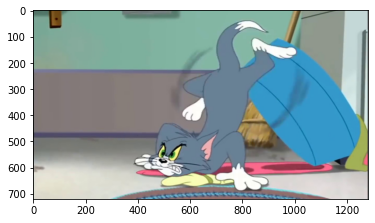

In [8]:
img = plt.imread('frame10.jpg')   # reading image using its name
plt.imshow(img)

In [9]:
train_df=pd.read_csv('Train.csv')
train_df.head()

,Frame_ID,Emotion
0,frame0.jpg,happy
1,frame1.jpg,happy
2,frame2.jpg,surprised
3,frame3.jpg,surprised
4,frame4.jpg,angry


In [10]:
X = [ ]     # creating an empty array
for img_name in train_df.Frame_ID:
    img = plt.imread(img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)

In [11]:
train_df['Emotion'].value_counts()

Unknown      116
surprised     68
sad           40
happy         37
angry         37
Name: Emotion, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()

train_df['Emotion']=label.fit_transform(train_df['Emotion'])
Emotions=label.classes_
Emotions

array(['Unknown', 'angry', 'happy', 'sad', 'surprised'], dtype=object)

In [13]:
y = train_df.Emotion
dummy_y = np_utils.to_categorical(y) 

In [14]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [15]:
X = preprocess_input(X) 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Building Model

In [55]:
image_input = Input(shape=(224, 224, 3))
base_model = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')

In [56]:
X_train=base_model.predict(X_train)
X_val=base_model.predict(X_val)
X_test_predict=base_model.predict(X_test)
X_train.shape,X_val.shape, X_test_predict.shape

((178, 7, 7, 512), (60, 7, 7, 512), (60, 7, 7, 512))

In [57]:
X_train=X_train.reshape(178,7*7*512)
X_val=X_val.reshape(60,7*7*512)
X_test_predict=X_test_predict.reshape(60,7*7*512)

In [58]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(5, activation='softmax'))    # output layer
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_7 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 25,696,261
Trainable params: 25,696,261
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
6/6 [==============================] - 0s 37ms/step - loss: 4.5118 - accuracy: 0.3933 - val_loss: 2.0718 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 1.9435 - accuracy: 0.6461 - val_loss: 1.1318 - val_accuracy: 0.7667
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 1.0705 - accuracy: 0.7079 - val_loss: 0.8116 - val_accuracy: 0.7000
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5239 - accuracy: 0.8596 - val_loss: 0.8606 - val_accuracy: 0.6833
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5110 - accuracy: 0.8202 - val_loss: 0.8734 - val_accuracy: 0.6667
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 0.4312 - accuracy: 0.9045 - val_loss: 0.6083 - val_accuracy: 0.8000
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.3646 - accuracy: 0.8933 - val_loss: 0.5337 - val_accuracy: 0.8167
Epoch 8/100
6/6 [===

Text(0.5, 1.0, 'Accuracy Curves')

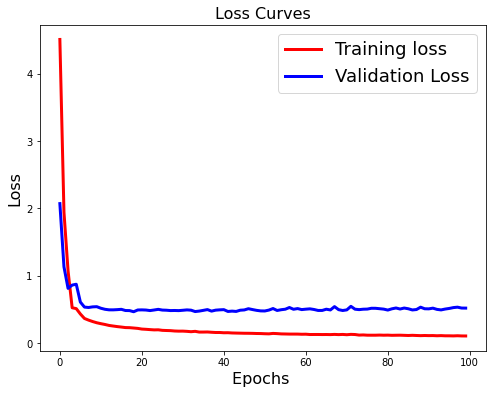

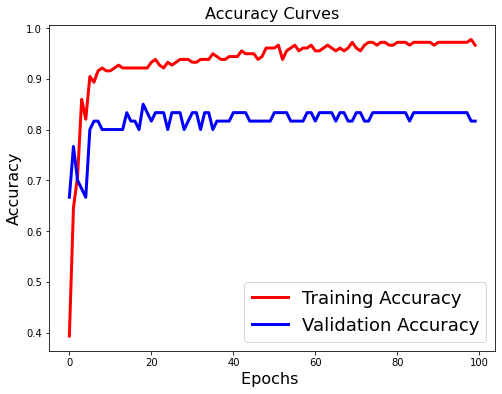

In [61]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [24]:
from tensorflow.keras.applications import ResNet50

image_input = Input(shape=(224, 224, 3))
base_model = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [28]:
X_train=base_model.predict(X_train)
X_val=base_model.predict(X_val)
X_test_predict=base_model.predict(X_test)
X_train.shape,X_val.shape, X_test_predict.shape

((178, 7, 7, 2048), (60, 7, 7, 2048), (60, 7, 7, 2048))

In [29]:
X_train=X_train.reshape(178,7*7*2048)
X_val=X_val.reshape(60,7*7*2048)
X_test_predict=X_test_predict.reshape(60,7*7*2048)

In [30]:
model_1 = Sequential()
model_1.add(InputLayer((7*7*2048,)))    # input layer
model_1.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model_1.add(Dense(5, activation='softmax'))    # output layer
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              102761472 
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 102,766,597
Trainable params: 102,766,597
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
history_1 = model_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
6/6 [==============================] - 1s 72ms/step - loss: 4.8487 - accuracy: 0.4607 - val_loss: 3.1314 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 0s 37ms/step - loss: 2.8750 - accuracy: 0.6236 - val_loss: 2.2394 - val_accuracy: 0.5667
Epoch 3/100
6/6 [==============================] - 0s 36ms/step - loss: 1.6315 - accuracy: 0.6517 - val_loss: 1.0450 - val_accuracy: 0.6667
Epoch 4/100
6/6 [==============================] - 0s 35ms/step - loss: 0.8208 - accuracy: 0.7360 - val_loss: 0.8281 - val_accuracy: 0.6667
Epoch 5/100
6/6 [==============================] - 0s 35ms/step - loss: 0.7862 - accuracy: 0.7191 - val_loss: 0.6566 - val_accuracy: 0.7167
Epoch 6/100
6/6 [==============================] - 0s 36ms/step - loss: 0.6692 - accuracy: 0.8090 - val_loss: 0.5652 - val_accuracy: 0.8000
Epoch 7/100
6/6 [==============================] - 0s 36ms/step - loss: 0.5913 - accuracy: 0.7921 - val_loss: 0.6058 - val_accuracy: 0.7667
Epoch 8/100
6/6 [===

Text(0.5, 1.0, 'Accuracy Curves')

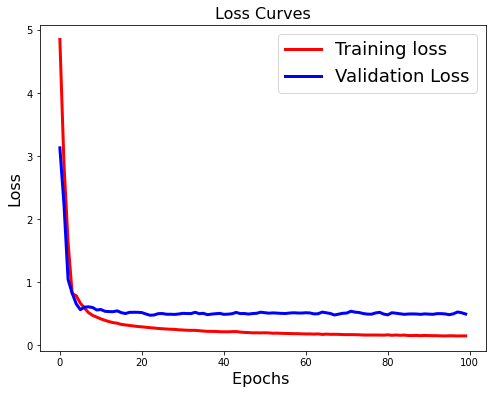

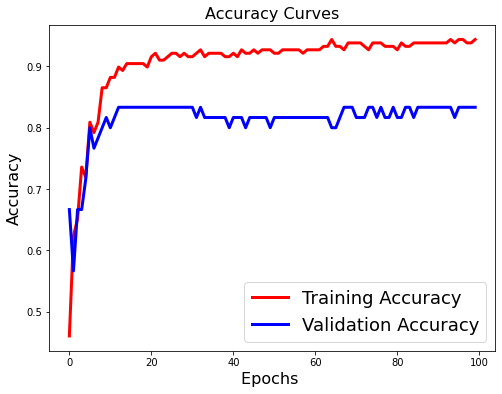

In [33]:
plt.figure(figsize=[8,6])
plt.plot(history_1.history['loss'],'r',linewidth=3.0)
plt.plot(history_1.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_1.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_1.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# Testing of the model

In [62]:
count = 0
videoFile = "Test Tom and Jerry.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")


Done!


In [63]:
test_df=pd.read_csv('Test.csv')
test_df.head()

,Frame_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [64]:
test_image=[]
for frame in test_df['Frame_ID']:
  img=plt.imread(''+frame)
  test_image.append(img)
test_ima=np.array(test_image)

In [65]:
test_image=[]
for i in range(0,test_ima.shape[0]):
  a = resize(test_ima[i], preserve_range=True, output_shape=(224,224)).astype(int)
  test_image.append(a)
test_image = np.array(test_image)

In [66]:
test_image = preprocess_input(test_image)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

In [67]:
predictions = model.predict(test_image)
predict_classes=predictions.argmax(axis=1)
predict_classes[:20]

array([1, 2, 0, 2, 3, 0, 0, 0, 0, 2, 3, 3, 1, 3, 4, 4, 2, 1, 2, 3])

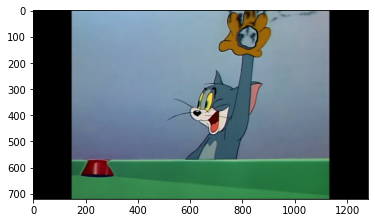

In [68]:
test_img=plt.imread('test19.jpg')
plt.imshow(test_img)

In [69]:
Emotions[4]

'surprised'